In [1]:
!pip -q install pandas

In [2]:
from __future__ import print_function
import collections
import cv2
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

%matplotlib inline

1. Load dataset

In [3]:
dataset_path = './faces100/'
if not os.path.isdir(dataset_path):
    !unzip -q faces100.zip

Load description

In [4]:
# labels_path = './val2017_faces.csv'
labels_path = './faces100.csv'
dataframe = pd.read_csv(labels_path,sep=" ", names=["filename", "x1", "y1", "x2", "y2"])

2 Detect with haar and lbp cascades

In [5]:
def get_real_label(df, image_name, w, h):
    real_labels = []
    labels = df.loc[df['filename'] == image_name]
    for index, label in labels.iterrows():
        x1 = int(label['x1'] * w)
        y1 = int(label['y1'] * h)
        x2 = int(label['x2'] * w)
        y2 = int(label['y2'] * h)
        real_labels.append([x1, y1, x2, y2])
    return real_labels

In [6]:
def detect(frame, cascade):
    """
    :param frame: input colored image
    :param cascade: cascade type
    :return: face box [x1, y1, x2, y2]
    """
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_gray = cv2.equalizeHist(frame_gray)
    faces = cascade.detectMultiScale(frame_gray)
    # w,h to x2, y2
    for face in faces:
        face[2] = face[0]+face[2]
        face[3] = face[1]+face[3]
    return faces

In [7]:
# Params:
face_cascade_haar_path = '/home/kuskov/opencv/data/haarcascades/haarcascade_frontalface_alt.xml'
face_cascade_lbp_path = '/home/kuskov/opencv/data/lbpcascades/lbpcascade_frontalface.xml'

#-- 0. Init classifiers:
face_cascade_haar = cv2.CascadeClassifier()
face_cascade_lbp = cv2.CascadeClassifier()


#-- 1. Load the cascades
if not face_cascade_haar.load(cv2.samples.findFile(face_cascade_haar_path)):
    print('--(!)Error loading face cascade haar')
    exit(0)

if not face_cascade_lbp.load(cv2.samples.findFile(face_cascade_lbp_path)):
    print('--(!)Error loading face cascade lbp')
    exit(0)


images_arr = os.listdir(dataset_path)
images_arr.sort()

detection_results = {}

for frame_name in images_arr:

    # Detect:
    frame = cv2.imread(dataset_path + frame_name)
    height, width, _ = frame.shape
    haar_faces = detect(frame, face_cascade_haar)

    lbp_faces = detect(frame, face_cascade_lbp)

    real_faces = np.asarray(get_real_label(dataframe, frame_name, width, height), "int32")

    # for real_face in lbp_faces:
    #     frame = cv2.rectangle(frame, (real_face[0],real_face[1]),(real_face[2],real_face[3]),(0,0,255),1)
    # for real_face in haar_faces:
    #     frame = cv2.rectangle(frame, (real_face[0],real_face[1]),(real_face[2],real_face[3]),(255,0,0),1)
    # for real_face in real_faces:
    #     frame = cv2.rectangle(frame, (real_face[0],real_face[1]),(real_face[2],real_face[3]),(255,255,255),1)
    #
    # cv2.imshow("",frame)
    # cv2.waitKey(0)

    res = collections.namedtuple("Result", "haar lbp real")

    detection_results[frame_name] = res(haar_faces, lbp_faces, real_faces)

3. IOU calculation and Confusion matrix

In [8]:
def iou_calc(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [27]:
def confusion_matrix_calculation(detection_results, iou_value):
    conf_m_haar = {
        "TP":0,"FN":0,"FP":0,"TN":0,"TP_cnt":[],"detects_cnt":[]
    }
    conf_m_lbp = {
        "TP":0,"FN":0,"FP":0,"TN":0,"TP_cnt":[],"detects_cnt":[]
    }
    dets = 0
    counts = 0
    for key in detection_results:
        counts+=1
        # HAAR
        if len(detection_results[key].haar) > 0:
            dets += len(detection_results[key].haar)
            for box in detection_results[key].haar:
                iou = iou_calc(detection_results[key].real[0], box,)
                if iou > iou_value:
                    conf_m_haar["TP"] += 1
                else:
                    conf_m_haar["FP"] += 1
        else:
            conf_m_haar["FN"] += 1
        conf_m_haar["TP_cnt"].append(conf_m_haar["TP"])
        conf_m_haar["detects_cnt"].append(dets)
        #LBP

        if len(detection_results[key].lbp) > 0:
            for box in detection_results[key].lbp:
                iou = iou_calc(detection_results[key].real[0], box,)
                if iou > iou_value:
                    conf_m_lbp["TP"] += 1
                else:
                    conf_m_lbp["FP"] += 1
        else:
            conf_m_lbp["FN"] += 1
        conf_m_lbp["TP_cnt"].append(conf_m_lbp["TP"])
        conf_m_lbp["detects_cnt"].append(dets)

    return conf_m_haar, conf_m_lbp

In [28]:
iou_values = [0.25, 0.5, 0.75, 0.95]

def precision_recall_f1_printer(conf_m):
    P = conf_m["TP"]/(conf_m["TP"] + conf_m["FP"])
    R = conf_m["TP"]/(conf_m["TP"] + conf_m["FN"])
    F = 2*((P*R)/(P+R+1e-10))
    print("Precision - {}, Recall - {} , F1 - {}".format(P, R, F))

for iou_value in iou_values:
    conf_m_haar, conf_m_lbp = confusion_matrix_calculation(detection_results, iou_value)
    print("IOU {}".format(iou_value))
    print("HAAR: ")
    precision_recall_f1_printer(conf_m_haar)
    print("LBP: ")
    precision_recall_f1_printer(conf_m_lbp)

    print("*******************")


IOU 0.25
HAAR: 
Precision - 0.7959183673469388, Recall - 0.42857142857142855 , F1 - 0.5571428570973571
LBP: 
Precision - 0.7288135593220338, Recall - 0.4725274725274725 , F1 - 0.5733333332856089
*******************
IOU 0.5
HAAR: 
Precision - 0.7959183673469388, Recall - 0.42857142857142855 , F1 - 0.5571428570973571
LBP: 
Precision - 0.6440677966101694, Recall - 0.4418604651162791 , F1 - 0.5241379309862163
*******************
IOU 0.75
HAAR: 
Precision - 0.2653061224489796, Recall - 0.2 , F1 - 0.2280701753895814
LBP: 
Precision - 0.1694915254237288, Recall - 0.1724137931034483 , F1 - 0.17094017089017458
*******************
IOU 0.95
HAAR: 
Precision - 0.0, Recall - 0.0 , F1 - 0.0
LBP: 
Precision - 0.0, Recall - 0.0 , F1 - 0.0
*******************


4. AP calculation

[1, 1, 1, 2, 3, 3, 3, 3, 4, 4, 5, 6, 6, 6, 7, 8, 9, 9, 9, 9, 10, 11, 11, 12, 12, 13, 14, 15, 15, 15, 16, 17, 18, 19, 19, 19, 20, 20, 21, 21, 21, 21, 21, 21, 23, 24, 25, 26, 26, 26, 26, 26, 26, 27, 27, 27, 28, 28, 28, 28, 29, 29, 30, 30, 31, 32, 32, 33, 33, 34, 35, 36, 36, 37, 38, 39, 39, 40, 40, 41, 41, 41, 42, 43, 44, 45, 45, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 48, 48, 49]
[1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 5, 6, 7, 7, 7, 7, 8, 9, 9, 10, 10, 11, 11, 12, 12, 12, 13, 14, 15, 15, 15, 15, 16, 16, 17, 17, 17, 17, 17, 17, 18, 19, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 22, 22, 22, 22, 22, 22, 23, 23, 24, 25, 25, 26, 26, 27, 28, 29, 29, 30, 31, 32, 32, 33, 33, 34, 34, 34, 35, 36, 37, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]


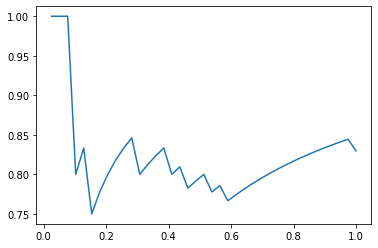

In [29]:
conf_m_haar, conf_m_lbp = confusion_matrix_calculation(detection_results, 0.25)

tp_cnt = conf_m_haar["TP_cnt"]
detects_cnt = conf_m_haar["detects_cnt"]
print(detects_cnt)
print(tp_cnt)
ap_precision, ap_recall, inter_p = [], [], []

prev_precision = None
prev_recall = None

for idx, tp in enumerate(tp_cnt):
    # precision = tp/(idx+1)
    # recall = tp/conf_m_haar["TP"]

    # precision = tp/((detector_cnt[idx]))
    # recall = tp/conf_m_haar["TP"]

    precision = tp/(detects_cnt[idx]) # tp/tp+fp
    recall = tp/conf_m_haar["TP"]

    if len(ap_recall) > 0:
        if recall == ap_recall[-1]:
            precision = ap_precision[-1]

    ap_precision.append(precision)
    ap_recall.append(recall)
    inter_p.append(precision)

plt.plot( ap_recall, inter_p)
plt.show()

In [ ]:
# example of ap calculation
# make table
# https://www.youtube.com/watch?v=QdWidmgLwbw
# make graph
# https://www.youtube.com/watch?v=t98TA2RYQvw
